# Reproduce the Ikonomi 2020 model

>Ikonomi N, Kühlwein SD, Schwab JD, Kestler HA. Awakening the HSC: Dynamic Modeling of HSC Maintenance Unravels Regulation of the TP53 Pathway and Quiescence. Front Physiol. 2020 Jul 31;11:848. doi: 10.3389/fphys.2020.00848. PMID: 32848827; PMCID: PMC7411231.

**Goal:**
   
To unravel new mechanistic insights in the maintenance of hematopoietic stem cell quiescence, with particular attention to TP53 regulation.
  
**Knowledge source:**
  
Literature review

**Representation:**
  
Boolean network
Codes available at supplementary and https://github.com/sysbio-bioinf/HSC-boolean-network-model  

**Tools:**
  
The java framework ViSiBooL was used for modeling
The analysis of the dynamic behavior of the HSC model was performed by synchronous updates with the R package BoolNet
  

**in silico validation:**
  
They tested the regulatory model by assessing its ability to recapitulate different knockout conditions, and showed that the model could recapitulate the phenotype of published mouse models. 

In [1]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

In [2]:
import ginsim
import biolqm
import maboss
import pypint
import numpy as np
import pandas as pd
from colomoto_jupyter import tabulate # for fixpoint table display
from itertools import combinations  # for iterating over sets
import matplotlib.pyplot as plt # for modifying plots
from scipy.stats import pearsonr # for calculating the pearson correlation
from rpy2.robjects.packages import importr
from rpy2.robjects import IntVector
from rpy2.robjects.vectors import ListVector
from rpy2 import robjects
from rpy2.robjects import conversion
from rpy2.robjects.conversion import localconverter
from rpy2.robjects import pandas2ri
boolnet = importr("BoolNet")
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib.colors as colors

This notebook has been executed using the docker image `colomoto/colomoto-docker:2024-03-01`

## Regulatory graph visualization with GINsim

The model is downloaded from the [Biodivine Boolean Models (BBM) Benchmark Dataset](https://github.com/sybila/biodivine-boolean-models/tree/main/models/%5Bid-100%5D__%5Bvar-18%5D__%5Bin-3%5D__%5BACUTE-MYELOID-LEUKEMIA%5D),which is taken directly from the text in the paper.

First visualize the network model.   
 

In [22]:
ikonomi = biolqm.load("Ikonomi2020_updated.sbml")
ikonomi_lrg = biolqm.to_ginsim(ikonomi)
ginsim.show(ikonomi_lrg)

## Boolean network simulations of the model

As described in the paper:  
>First, we exhaustively simulated our model, obtaining four single state attractors. The network contains two external inputs (external quiescence and external cycling), resulting in four possible combinations. In accordance, each reached attractor shows a different combination of these nodes (Figure 2).

![Figure 2](figure2.jpeg)  
(Green indicates active nodes, blue indicates inactive ones.)  
  
We are going to reproduce these results.

### Experiment set-up
According to the paper, we are going to set up the simulations on `External quiescence` and `External cycling`.

In [4]:
# set the fix value for the simulations
lt = biolqm.perturbation(ikonomi, "External_quiescence%1 External_cycling%0")
st = biolqm.perturbation(ikonomi, "External_quiescence%1 External_cycling%1")
cyc = biolqm.perturbation(ikonomi, "External_quiescence%0 External_cycling%1")
un = biolqm.perturbation(ikonomi, "External_quiescence%0 External_cycling%0")

### Stable states calculation

In [7]:
# get the stable states
networks = [lt,st,cyc,un]
results = pd.DataFrame()
for network in networks:
    fps = biolqm.fixpoints(network)
    results = pd.concat([results, pd.DataFrame(fps)],ignore_index=True)
results.index = ["LT-HSC","ST-HSC","Cycling HSC","Unstimulated"]
results.T

,LT-HSC,ST-HSC,Cycling HSC,Unstimulated
External_quiescence,1,1,0,0
External_cycling,0,1,1,0
PIK3CA,0,1,1,0
TSC1,1,0,0,1
MTOR,0,1,1,0
FOXO3,1,0,0,0
ATM,1,0,0,0
ROS1,0,1,1,1
Mitochondria,0,1,1,0
Autophagy,0,0,0,0


The results are identical.

## The asynchronous stable states

In [48]:
model_name = "Ikonomi2020"
net = boolnet.loadNetwork(model_name + ".txt")
attr = boolnet.getAttractors(net)
print(attr)

Attractor 1 is a simple attractor consisting of 1 state(s):

 |--<-----------------------------------|
 V                                      |
 100101100000010010111111000000000000   |
 V                                      |
 |-->-----------------------------------|


Genes are encoded in the following order: EXTERNAL_QUIESCENCE EXTERNAL_CYCLING PIK3CA TSC1 MTOR FOXO3 ATM ROS1 MITOCHONDRIA AUTOPHAGY NRAS ETS1 MEFV GSK3B CTNNB1 MYC BMI1 MDM2 TP53 CDKN1C CDKN1A CDKN1B GFI1 RB1 E2F1 CCND1 CCNE1 S_PHASE AKT1 CDKN2D CDKN2A PRO_APOPTOTIC_PROTEINS ANTI_APOPTOTIC_PROTEINS CYCS APOPTOSIS SENESCENCE

Attractor 2 is a simple attractor consisting of 1 state(s):

 |--<-----------------------------------|
 V                                      |
 011010011010101111000000111110001000   |
 V                                      |
 |-->-----------------------------------|


Genes are encoded in the following order: EXTERNAL_QUIESCENCE EXTERNAL_CYCLING PIK3CA TSC1 MTOR FOXO3 ATM ROS1 MITOCHONDRIA A

In [49]:
# Activate the conversion context to use pandas DataFrame
pandas2ri.activate()

# Access the dataframe stored under the key '1'
attrr = boolnet.plotAttractors(attr)
r_df = attrr.rx2('1')

# Use the local converter context to manage the conversion to a numpy array
with localconverter(robjects.default_converter + pandas2ri.converter):
    np_array = np.array(r_df)

# Extract names from the R dataframe
row_names = list(r_df.rownames)
column_names = list(r_df.colnames)

# Create a pandas DataFrame from the numpy array
df = pd.DataFrame(np_array, index=row_names, columns=column_names)

df = df.T
df.index = df.index.str.replace('Attr', 'S')
df.to_csv('../SimulationResults/attr_' + model_name + '.csv')
df

,EXTERNAL_QUIESCENCE,EXTERNAL_CYCLING,PIK3CA,TSC1,MTOR,FOXO3,ATM,ROS1,MITOCHONDRIA,AUTOPHAGY,NRAS,ETS1,MEFV,GSK3B,CTNNB1,MYC,BMI1,MDM2,TP53,CDKN1C,CDKN1A,CDKN1B,GFI1,RB1,E2F1,CCND1,CCNE1,S_PHASE,AKT1,CDKN2D,CDKN2A,PRO_APOPTOTIC_PROTEINS,ANTI_APOPTOTIC_PROTEINS,CYCS,APOPTOSIS,SENESCENCE
S1.1,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
S2.1,0,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,0,0,0
S3.1,1,1,1,0,1,0,0,1,1,0,1,0,1,0,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
S4.1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,1,1,1,0,1,1,1


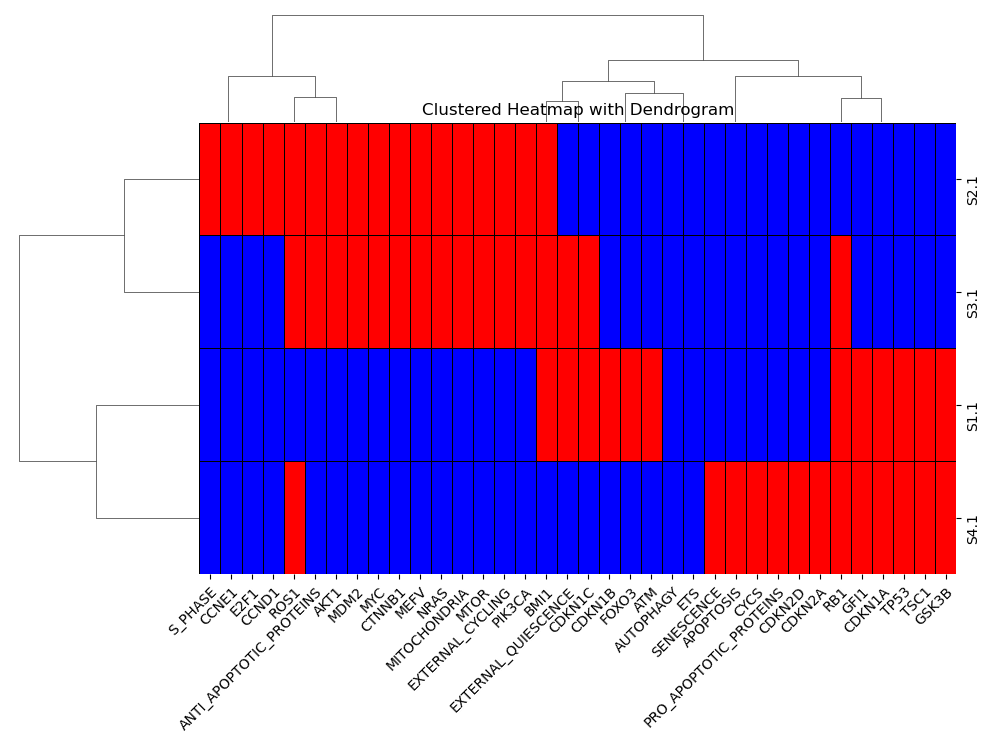

In [16]:
# Clustering
cmap = ListedColormap(['blue', 'red'])

g = sns.clustermap(df, method='ward', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(10, 8), cbar=False, col_cluster=True)
g.ax_heatmap.set_title('Clustered Heatmap with Dendrogram')
g.ax_heatmap.tick_params(axis='y', labelsize=10)  # Adjust y-tick label size if needed
g.ax_heatmap.tick_params(axis='x', labelsize=10)  # Adjust x-tick label size if needed, rotate if necessary
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels for better readability

# Hide the color bar space if it's not needed
g.cax.set_visible(False)

plt.show()

# Merge the Ikonomi 2020 model with the Palma 2021 model

There are three different combinations of rules tested here: 
- 'OR': rules from two models are combined simply using the 'OR' operator
- 'AND' : rules from two models are combined simply using the 'AND' operator
- 'Inhibitor wins': All inhibitors from the two models must be absented, while the activators are combined using the 'OR' operator.
    
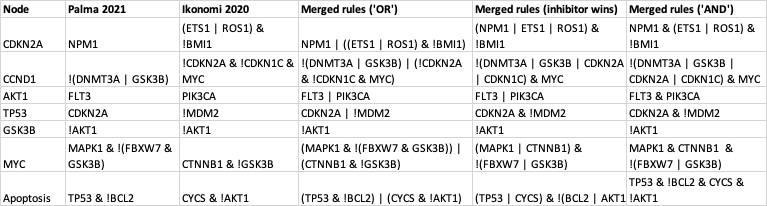  
    
Rules are edited in local GINsim and exported to SBML-qual format.

In [3]:
merged_and = biolqm.load("merged_and.sbml")
merged_inhibitor_wins = biolqm.load("merged_inhibitor_wins.sbml")
merged_or = biolqm.load("merged_or.sbml")
merged_lrg = biolqm.to_ginsim(merged_and)
ginsim.show(merged_lrg)

## Cluster the stable states

In [9]:
model1name = "Palma2021"
model2name = "Ikonomi2020"

merged_and_name = "../Models/merged_and_" + model1name + "_" + model2name
merged_inhibitor_wins_name = "../Models/merged_inhibitor_wins_" + model1name + "_" + model2name
merged_or_name = "../Models/merged_or_" + model1name + "_" + model2name

# load the network
merged_and = boolnet.loadNetwork(merged_and_name + ".txt")
merged_inhibitor_wins = boolnet.loadNetwork(merged_inhibitor_wins_name + ".txt")
merged_or = boolnet.loadNetwork(merged_or_name + ".txt")

# get the attractor states
attr_and = boolnet.getAttractors(merged_and)
attr_inhibitor_wins = boolnet.getAttractors(merged_inhibitor_wins)
attr_or = boolnet.getAttractors(merged_or)

In [51]:
for i in range(3):
    attr = [attr_and, attr_inhibitor_wins, attr_or][i]
    df_name = ["attr_merged_and","attr_merged_inhibitor_wins","attr_merged_or"][i]
    
    # Activate the conversion context to use pandas DataFrame
    pandas2ri.activate()
    
    # Access the dataframe stored under the key '1'
    attrr = boolnet.plotAttractors(attr)
    r_df = attrr.rx2('1')
    
    # Use the local converter context to manage the conversion to a numpy array
    with localconverter(robjects.default_converter + pandas2ri.converter):
        np_array = np.array(r_df)
    
    # Extract names from the R dataframe
    row_names = list(r_df.rownames)
    column_names = list(r_df.colnames)
    
    # Create a pandas DataFrame from the numpy array
    df = pd.DataFrame(np_array, index=row_names, columns=column_names)
    df = df.T
    df.index = df.index.str.replace('Attr', 'S')
    df.to_csv('../SimulationResults/' + df_name + "_" + model1name + "_" + model2name + '.csv')

In [10]:
# Define the order of columns as in the paper
column_order_1 = ['PROLIFERATION','STAT5A','SOX4','MAPK1','HOXA9','MEIS1','BCL2','FBXW7','NPM1','DNMT3A','CEBPA','ETV6','FLT3','MYC', 'AKT1', 'CCND1','TP53','CDKN2A','GSK3B','APOPTOSIS']
column_order_2 = ['MYC', 'AKT1', 'CCND1','TP53','CDKN2A','GSK3B','APOPTOSIS','S_PHASE','CCNE1','E2F1','ROS1','ANTI_APOPTOTIC_PROTEINS','MDM2','CTNNB1','MEFV','NRAS','MITOCHONDRIA','MTOR','EXTERNAL_CYCLING','PIK3CA','BMI1','EXTERNAL_QUIESCENCE','CDKN1B','FOXO3','ATM','AUTOPHAGY','ETS1','SENESCENCE','CYCS','PRO_APOPTOTIC_PROTEINS','CDKN2D','RB1','GFI1','CDKN1A','TSC1']
column_order_merged = ['PROLIFERATION','STAT5A','SOX4','MAPK1','HOXA9','MEIS1','BCL2','FBXW7','NPM1','DNMT3A','CEBPA','ETV6','FLT3','MYC', 'AKT1', 'CCND1','TP53','CDKN2A','GSK3B','APOPTOSIS', 'S_PHASE','CCNE1','E2F1','ROS1','ANTI_APOPTOTIC_PROTEINS','MDM2','CTNNB1','MEFV','NRAS','MITOCHONDRIA','MTOR','EXTERNAL_CYCLING','PIK3CA','BMI1','EXTERNAL_QUIESCENCE','CDKN1B','FOXO3','ATM','AUTOPHAGY','ETS1','SENESCENCE','CYCS','PRO_APOPTOTIC_PROTEINS','CDKN2D','RB1','GFI1','CDKN1A','TSC1']

# Model1 results
df1 = pd.read_csv("../SimulationResults/attr_" + model1name + ".csv", index_col = 0)
df1.index = df1.index.str.replace('S', 'P')
df1 = df1[column_order_1]

# Model2 results
df2 = pd.read_csv("../SimulationResults/attr_" + model2name + ".csv", index_col = 0)
df2.index = df2.index.str.replace('S', 'I')
df2 = df2[column_order_2]

# Merged results
df_and = pd.read_csv("../SimulationResults/attr_merged_and_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_and.index = df_and.index.str.replace('S', 'M')
df_and = df_and[column_order_merged]
df_and = pd.concat([df_and, df1, df2])

df_inhibitor_wins = pd.read_csv("../SimulationResults/attr_merged_inhibitor_wins_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_inhibitor_wins.index = df_inhibitor_wins.index.str.replace('S', 'M')
df_inhibitor_wins = df_inhibitor_wins[column_order_merged]
df_inhibitor_wins = pd.concat([df_inhibitor_wins, df1, df2])

df_or = pd.read_csv("../SimulationResults/attr_merged_or_" + model1name + "_" + model2name + '.csv', index_col = 0)
df_or.index = df_or.index.str.replace('S', 'M')
df_or = df_or[column_order_merged]
df_or = pd.concat([df_or, df1, df2])

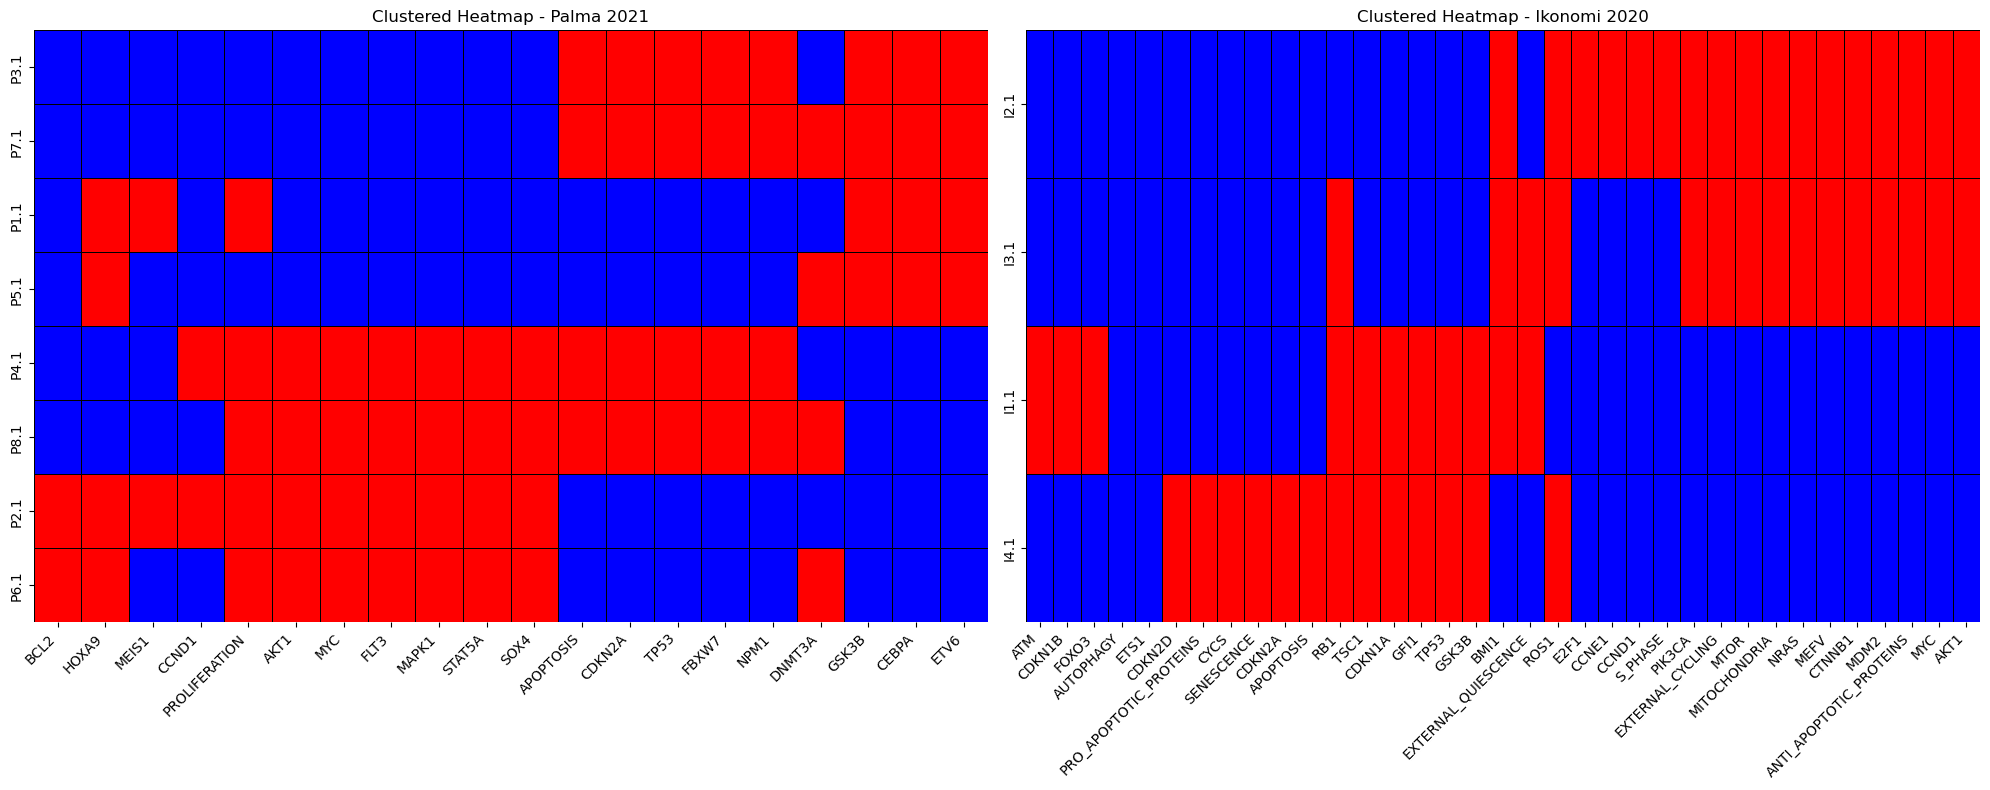

In [14]:
# Visualize
cmap = ListedColormap(['blue', 'red'])

g1 = sns.clustermap(df1, method='average', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 8), cbar=False, col_cluster=True)
plt.close(g1.fig)  
g2 = sns.clustermap(df2, method='average', metric='euclidean', cmap=cmap, linewidths=0.5, linecolor='black', figsize=(8, 8), cbar=False, col_cluster=True)
plt.close(g2.fig) 

# Create a new figure to hold both clustermaps
fig = plt.figure(figsize=(20,8))
gs = GridSpec(1, 2, figure=fig)

# Draw the first clustermap in the left subplot
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(g1.data2d, ax=ax1, cbar=False, cmap=cmap, linewidths=0.5, linecolor='black')
ax1.set_title('Clustered Heatmap - Palma 2021')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right')

# Draw the second clustermap in the right subplot
ax2 = fig.add_subplot(gs[0, 1])
sns.heatmap(g2.data2d, ax=ax2, cbar=False, cmap=cmap, linewidths=0.5, linecolor='black')
ax2.set_title('Clustered Heatmap - Ikonomi 2020')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')

# Show the combined figure
plt.tight_layout()
plt.show()

/tmp/ipykernel_27532/1823055460.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


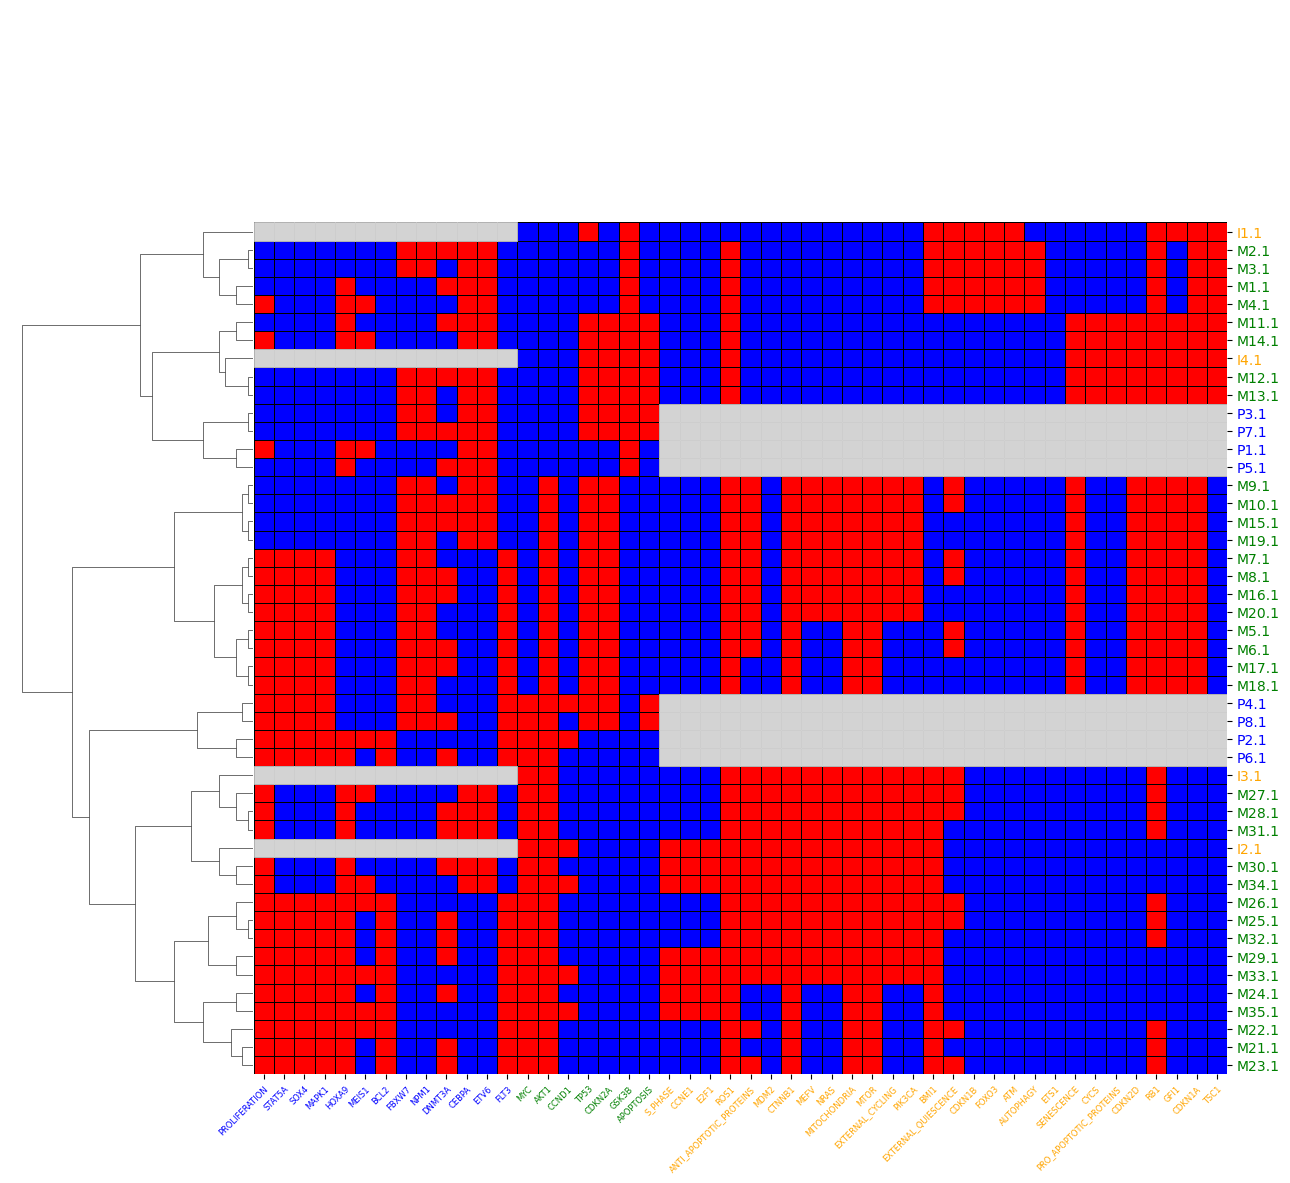

In [20]:
def heatmap(df, figsize=(13, 13)):
    # Create a custom colormap: blue for 0, red for 1
    cmap = colors.ListedColormap(['blue', 'red'])
    bounds = [-0.1, 0.5, 1.1]  # Boundaries to separate colors
    norm = colors.BoundaryNorm(bounds, cmap.N)

    # Fill NaN values with 0 for clustering
    df_filled = df.fillna(0)
    
    # Mask NaN values for clustering
    mask = df.isna()

    # Create the clustermap without considering NaN values
    g = sns.clustermap(df_filled, method='complete', metric='hamming', cmap=cmap, norm=norm,
                       linewidths=0.5, linecolor='black', figsize=figsize, cbar=False, col_cluster=False)
    g.ax_heatmap.tick_params(axis='y', labelsize=10)
    g.ax_heatmap.tick_params(axis='x', labelsize=6)
    plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")  # Rotate x-tick labels
    g.cax.set_visible(False)

    # Determine the color based on the label text
    def get_ylabel_color(label):
        if label.startswith('P'):
            return 'blue'
        elif label.startswith('I'):
            return 'orange'
        elif label.startswith('M'):
            return 'green'
        else:
            return 'black'  # Default color
    
    def get_xlabel_color(label):
        if label in set(column_order_merged) - set(column_order_1):
            return 'orange'
        elif label in set(column_order_merged) - set(column_order_2):
            return 'blue'
        else:
            return 'green'
            
    # Set the color of labels based on their text
    for label in g.ax_heatmap.get_yticklabels():
        label.set_color(get_ylabel_color(label.get_text()))
    for label in g.ax_heatmap.get_xticklabels():
        label.set_color(get_xlabel_color(label.get_text()))

    # Add grey patches on NA grid cells based on clustered positions
    for (i, j), val in np.ndenumerate(df.values):
        if pd.isna(val):
            # Get the correct row and column indices in the clustered heatmap
            row_index = df.index[i]
            col_index = df.columns[j]
            # Find the positions in the clustered heatmap
            row_pos = np.where(g.data2d.index == row_index)[0][0]
            col_pos = np.where(g.data2d.columns == col_index)[0][0]
            # Create a rectangle patch with light grey fill
            rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)
            g.ax_heatmap.add_patch(rect)
    
    plt.show()

heatmap(df_inhibitor_wins)

/tmp/ipykernel_27532/1823055460.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


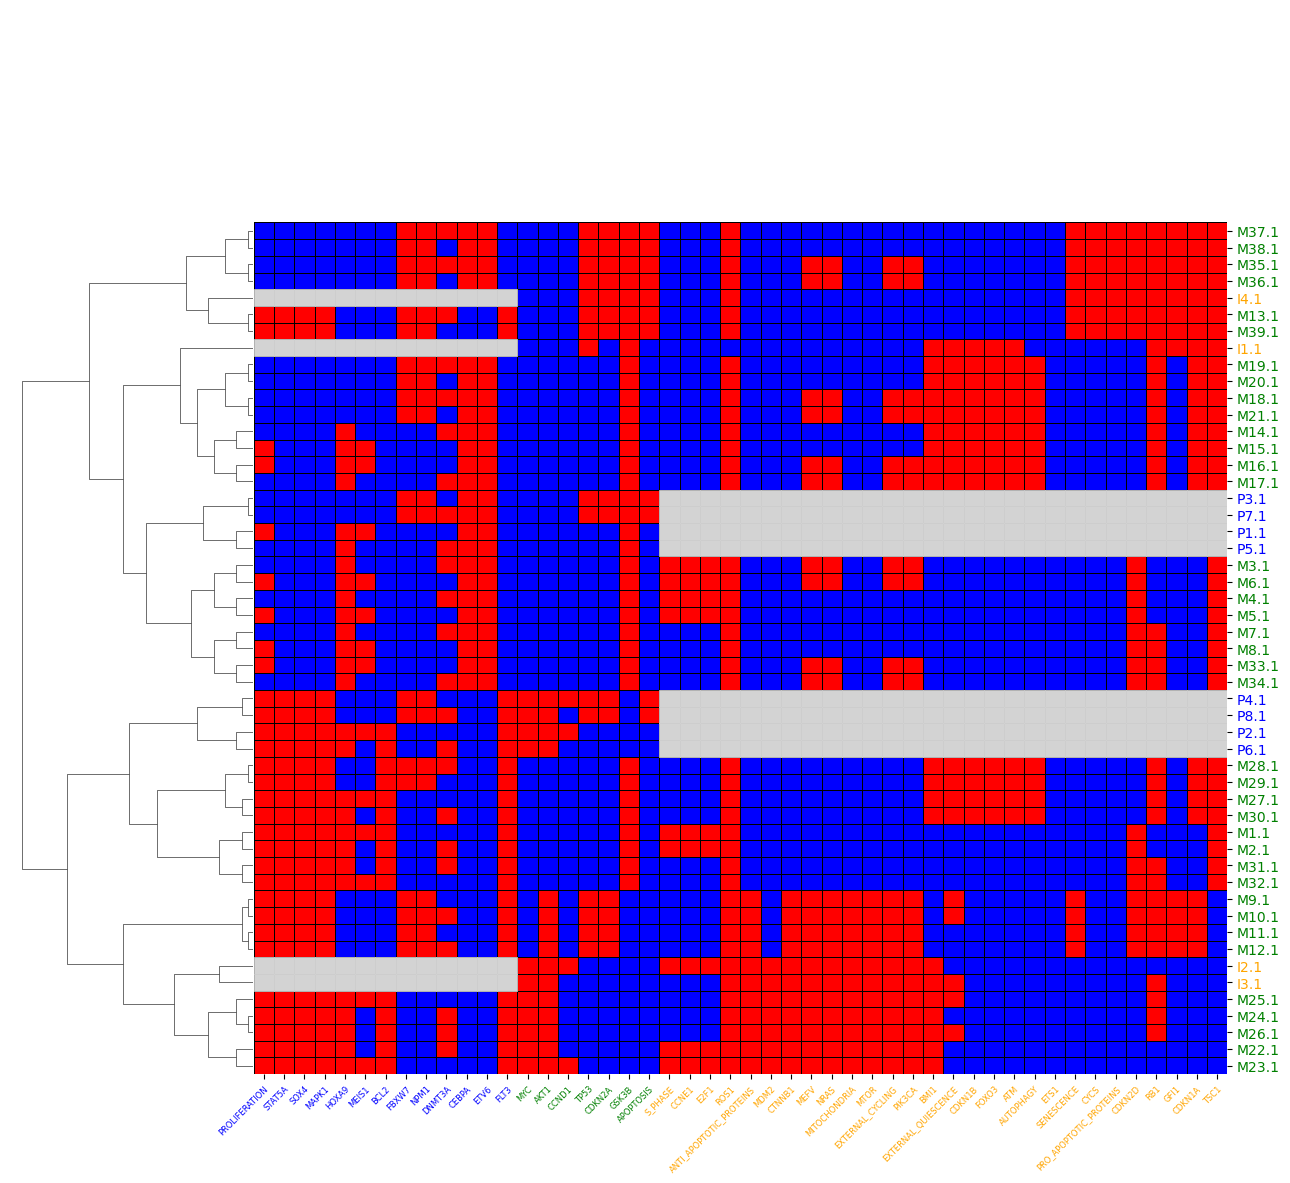

In [21]:
heatmap(df_and)

/tmp/ipykernel_27532/1823055460.py:56: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = patches.Rectangle((col_pos, row_pos), 1, 1, fill=True, color='lightgrey', edgecolor='black', linewidth=0.5)


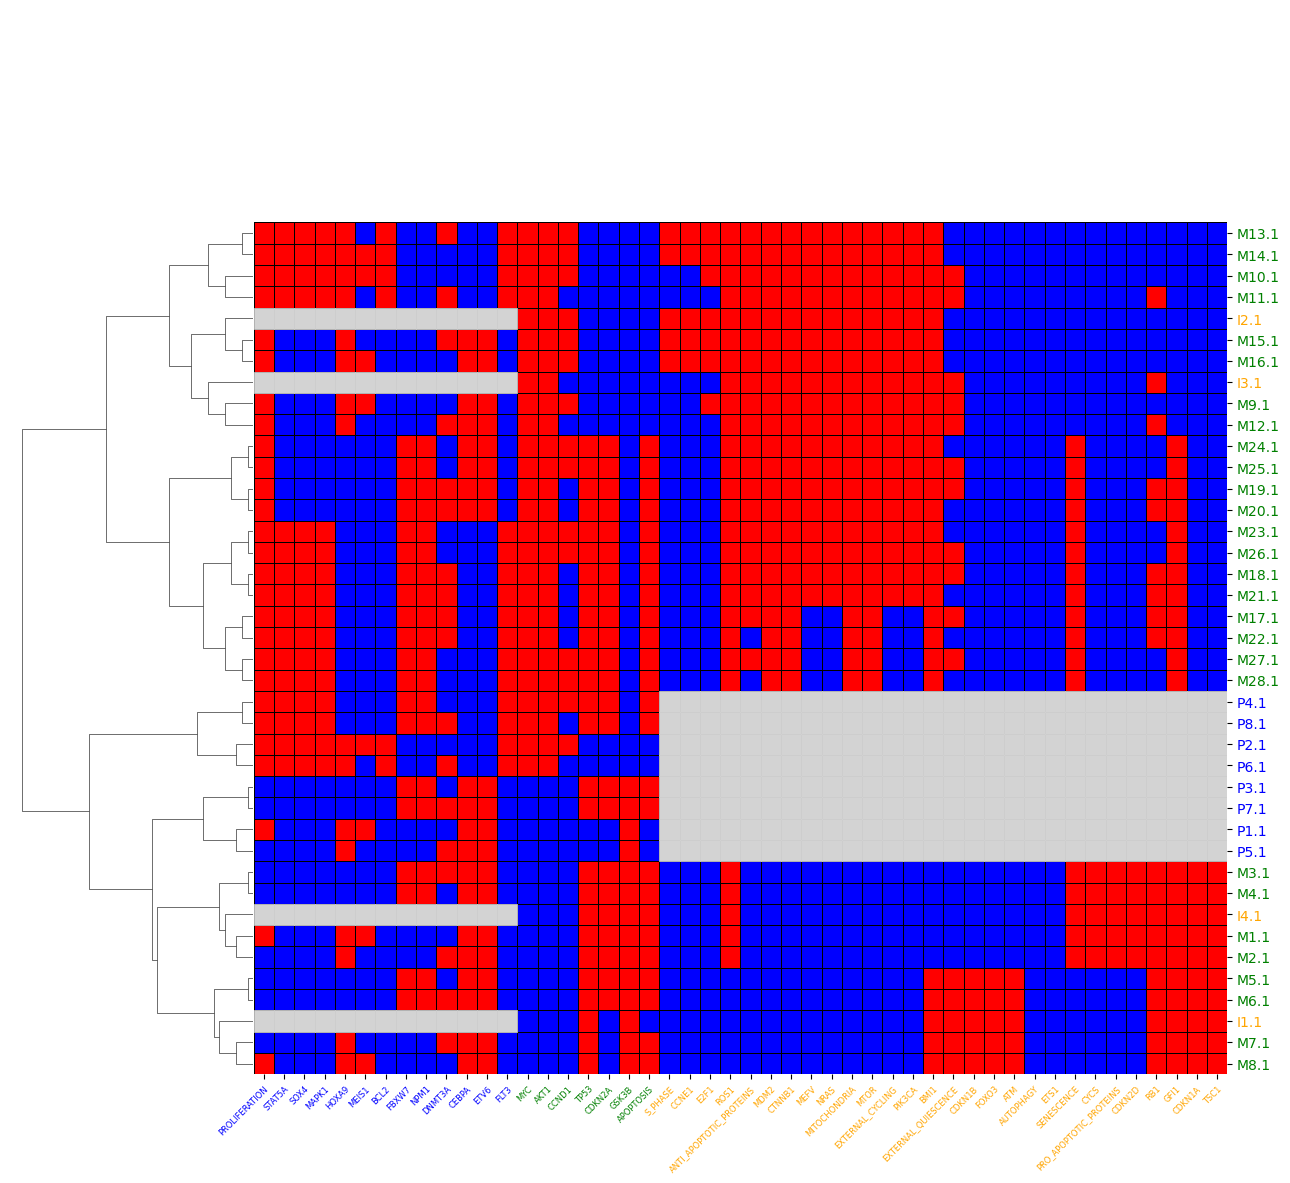

In [22]:
heatmap(df_or)

## Validation against previous Palma 2021 results
### Harzard ratio for death
>We next evaluated whether we could use these models to infer some clinical outcomes of patients carrying mutations in NPM1 and/or DNMT3A and/or FLT3. To this end we made use of the clinical information provided by Papaemmanuil et al. reporting the impact of somatic mutations on overall survival and we compared the mutation-specific hazard ratios with the predictions of our models. As a proxy for the predictive power of our model, we defined the “integrated network phenotype” score, which is calculated by subtracting from the activation value of the phenotype “proliferation” the values of “apoptosis” and “differentiation”.

In [28]:
def simulation(model_file):
    model = biolqm.load(model_file)
    
    # set the fix value for the simulations
    wt = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%1")
    flt3 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%1")
    npm1 = biolqm.perturbation(model, "FLT3%0 DNMT3A%1 NPM1%0")
    dnmt3a = biolqm.perturbation(model, "FLT3%0 DNMT3A%0 NPM1%1")
    npm1_dnmt3a = biolqm.perturbation(model,"FLT3%0 DNMT3A%0 NPM1%0")
    flt3_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%1")
    flt3_npm1 = biolqm.perturbation(model, "FLT3%1 DNMT3A%1 NPM1%0")
    flt3_npm1_dnmt3a = biolqm.perturbation(model, "FLT3%1 DNMT3A%0 NPM1%0")

    # get the stable states
    networks = [wt,flt3,npm1,dnmt3a,npm1_dnmt3a,flt3_dnmt3a,flt3_npm1,flt3_npm1_dnmt3a]
    results = pd.DataFrame()
    for network in networks:
        fps = biolqm.fixpoints(network)
        # take average if multiple stable states exist
        results = pd.concat([results, pd.DataFrame(fps).mean().to_frame().T],ignore_index=True)
    results.index = ["wt","flt3","npm1","dnmt3a","npm1_dnmt3a","flt3_dnmt3a","flt3_npm1","flt3_npm1_dnmt3a"]
    
    # calculate the phenotype scores
    results['APOPTOSIS'] = results['TP53'] - results['BCL2']
    results['DIFFERENTIATION'] = results['CEBPA'] + results['ETV6'] - results['MEIS1']
    results['PROLIFERATION'] = results['CCND1'] + results['SOX4'] + results['MEIS1'] + results['STAT5A']
    
    # calculate the network scores
    results['NETWORK'] = results['PROLIFERATION'] - results['APOPTOSIS'] - results['DIFFERENTIATION']
    simulation_results = results.T.sort_index()
    return simulation_results

def hazard_ratio_pc(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio,simulation_results])
    
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    hazard_ratio_pc_results = pd.DataFrame()
    
    for phenotype in phenotypes:
        # Extract hazard ratio and phenotype values
        x = results.loc['Hazard_ratio', :]
        y = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        hazard_ratio_pc_results.loc[phenotype, 'pc'], hazard_ratio_pc_results.loc[phenotype, 'p_value'] = pearsonr(x, y)
    return hazard_ratio_pc_results
    

def hazard_ratio_plot(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    phenotypes = ['NETWORK', 'APOPTOSIS', 'DIFFERENTIATION', 'PROLIFERATION']
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    
    for i, phenotype in enumerate(phenotypes):
        ax = axes[i // 2, i % 2]
        # Extract hazard ratio and phenotype values
        y = results.loc['Hazard_ratio', :]
        x = results.loc[phenotype, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{phenotype} vs Hazard Ratio for Death')
        ax.set_ylabel('Hazard Ratio')
        ax.set_xlabel(phenotype)
    
        # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
        
        # Annotate Pearson Correlation and p-value
        if phenotype in ['APOPTOSIS', 'DIFFERENTIATION']:
            ax.text(0.05, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='left', verticalalignment='bottom')
        else:
            ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                    transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

def hazard_ratio_plot_network(simulation_results, hazard_ratio_file):
    hazard_ratio = pd.read_csv(hazard_ratio_file)
    hazard_ratio.index = ['Hazard_ratio']
    results = pd.concat([hazard_ratio, simulation_results])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    # Extract hazard ratio and phenotype values
    y = results.loc['Hazard_ratio', :]
    x = results.loc['NETWORK', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Hazard Ratio for Death vs Network score')
    ax.set_ylabel('Hazard Ratio for Death')
    ax.set_xlabel('Network score')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')

    plt.tight_layout()
    plt.show()

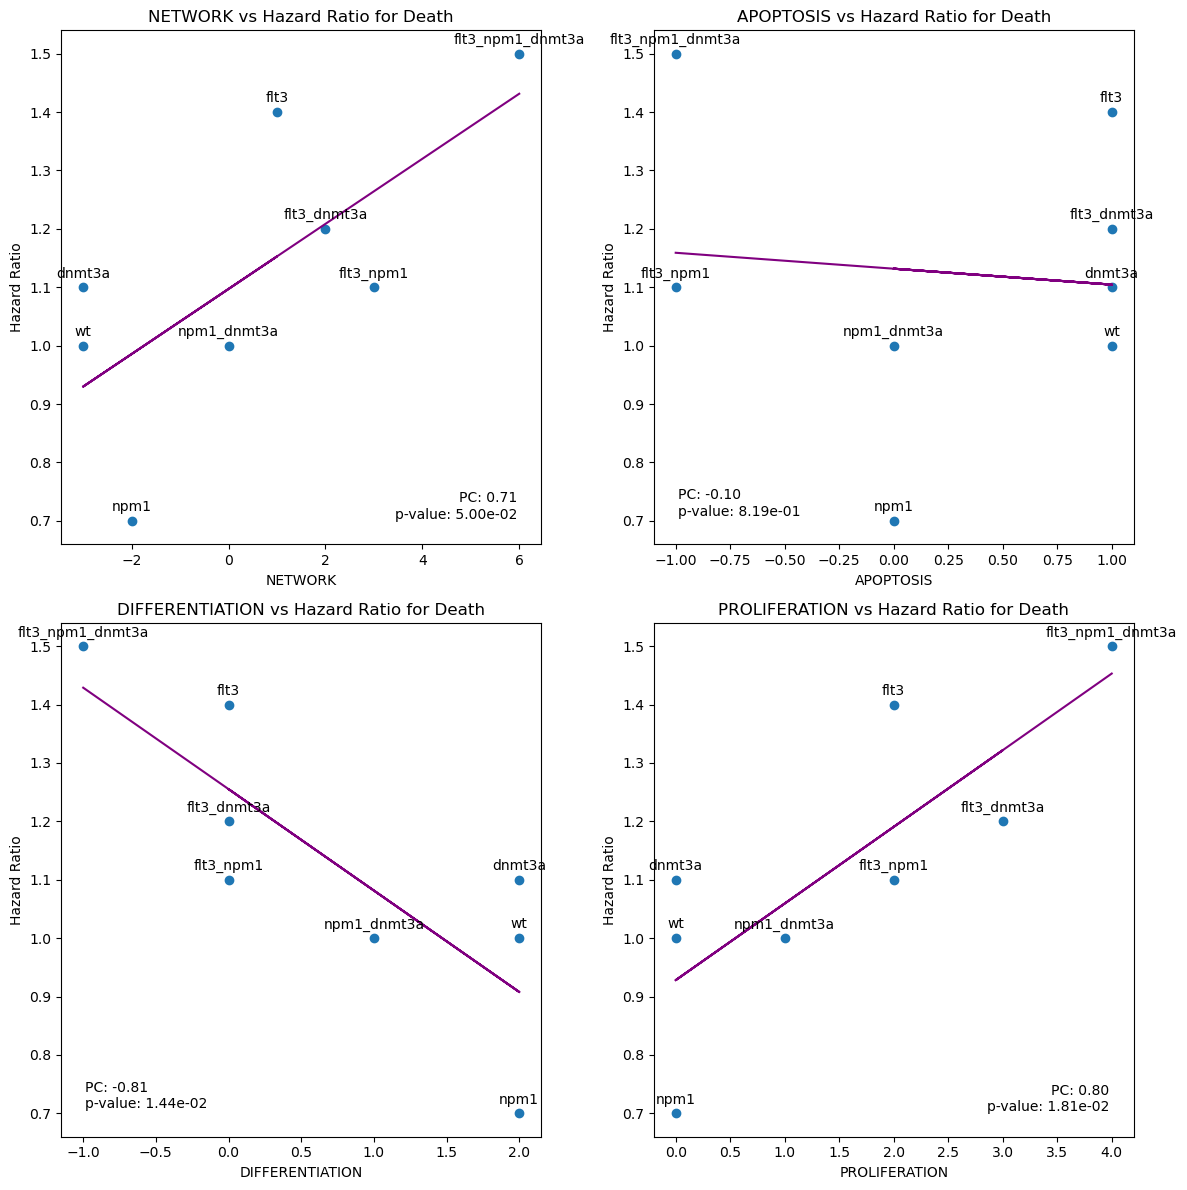

In [29]:
# Palma 2021's results
simulation_results_palma = simulation('Palma2021_nophe.sbml')
hazard_ratio_pc_palma = hazard_ratio_pc(simulation_results_palma, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_palma, 'Hazard Ratio for Death.csv')

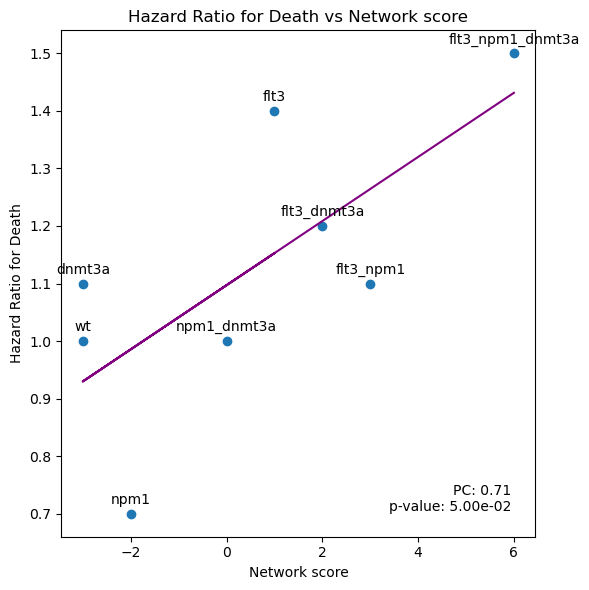

In [27]:
hazard_ratio_plot_network(simulation_results_palma, 'Hazard Ratio for Death.csv')

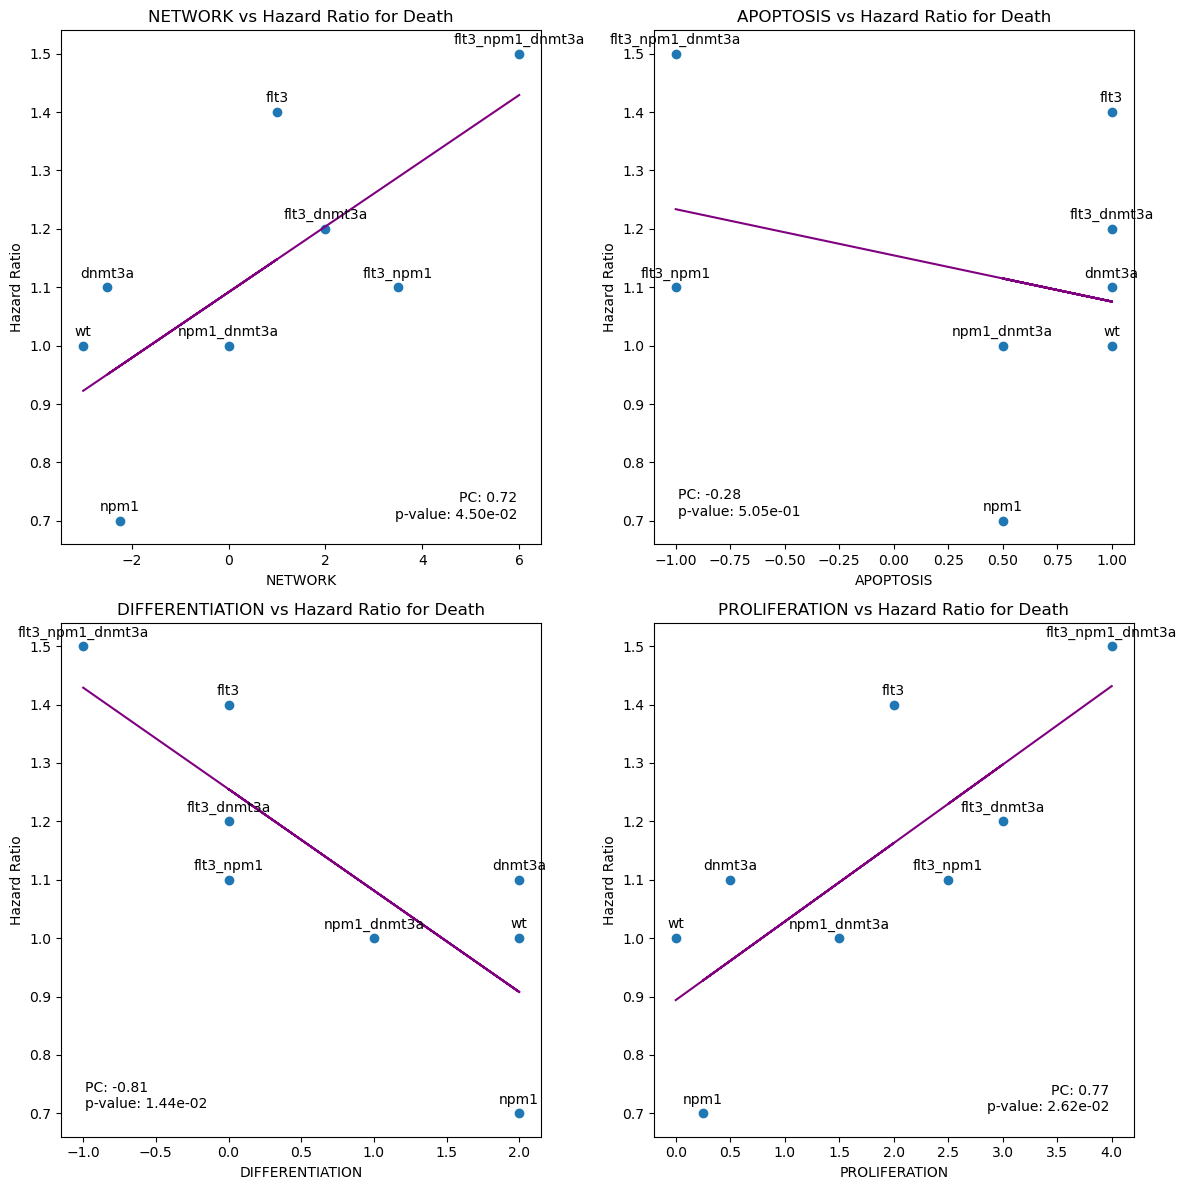

In [31]:
# Merged rules using 'OR'
simulation_results_or = simulation('merged_or.sbml')
hazard_ratio_pc_or = hazard_ratio_pc(simulation_results_or, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_or, 'Hazard Ratio for Death.csv')

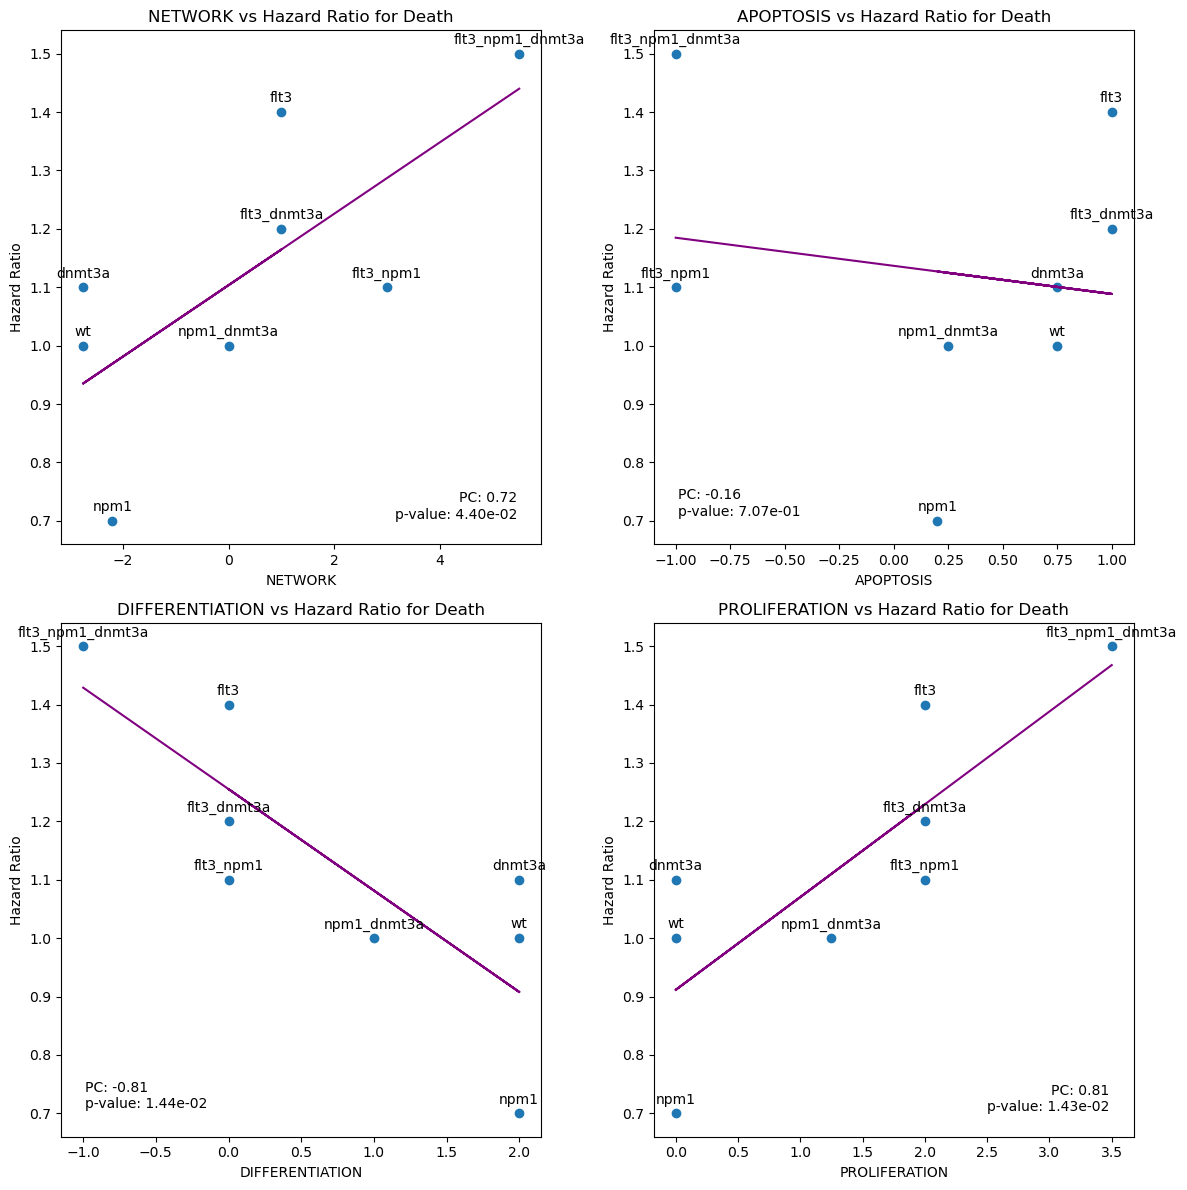

In [32]:
# Merged rules using 'Inhibitor wins'
simulation_results_inhibitor_wins = simulation('merged_inhibitor_wins.sbml')
hazard_ratio_pc_inhibitor_wins = hazard_ratio_pc(simulation_results_inhibitor_wins, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_inhibitor_wins, 'Hazard Ratio for Death.csv')

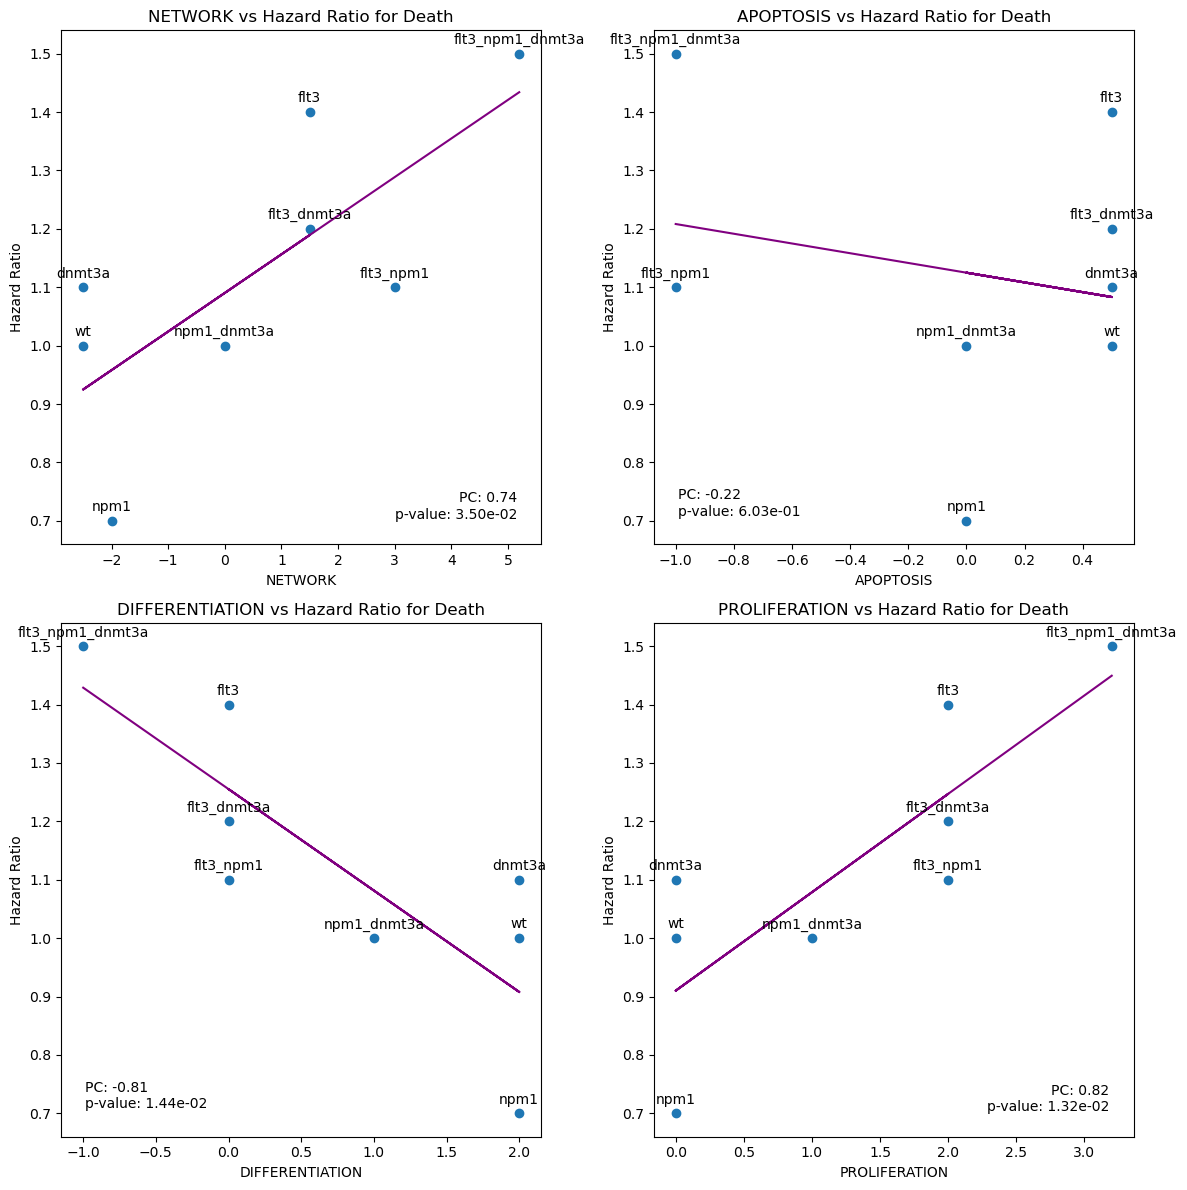

In [33]:
# Merged rules using 'AND'
simulation_results_and = simulation('merged_and.sbml')
hazard_ratio_pc_and = hazard_ratio_pc(simulation_results_and, 'Hazard Ratio for Death.csv')
hazard_ratio_plot(simulation_results_and, 'Hazard Ratio for Death.csv')

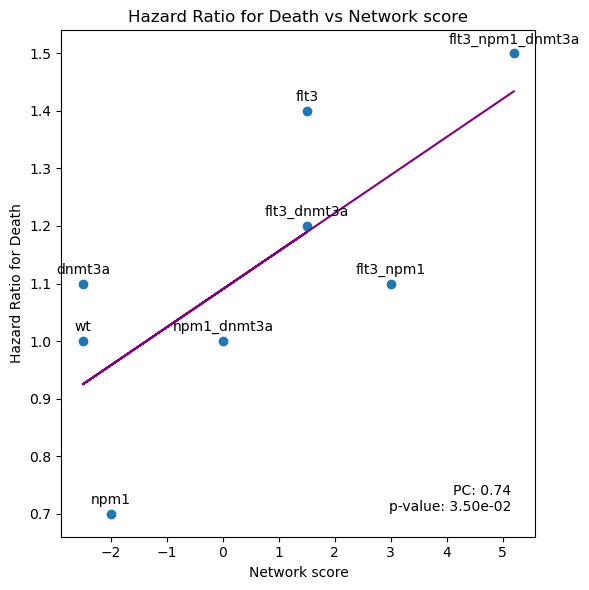

In [34]:
hazard_ratio_plot_network(simulation_results_and, 'Hazard Ratio for Death.csv')

In [43]:
# Display the results side by side
from IPython.display import display_html
def display_side_by_side(dfs: list, titles: list):
    """Display dataframes side by side with titles"""
    html_str = ''
    for df, title in zip(dfs, titles):
        df_html = df.to_html()
        df_html = df_html.replace('<table border="1" class="dataframe">', 
                                  f'<table border="1" class="dataframe" style="display:inline;margin-right:20px;"><caption style="text-align:center;font-weight:bold">{title}</caption>')
        html_str += df_html
    display_html(html_str, raw=True)

titles = ['Palma', 'OR', 'Inhibitor Wins', 'AND']
display_side_by_side([hazard_ratio_pc_palma, hazard_ratio_pc_or, hazard_ratio_pc_inhibitor_wins, hazard_ratio_pc_and], titles=titles)


,pc,p_value
NETWORK,0.706758,0.049989
APOPTOSIS,-0.096976,0.819306
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.796003,0.018109
,pc,p_value
NETWORK,0.717688,0.045013
APOPTOSIS,-0.277943,0.505075
DIFFERENTIATION,-0.811666,0.014430
PROLIFERATION,0.767542,0.026183
,pc,p_value


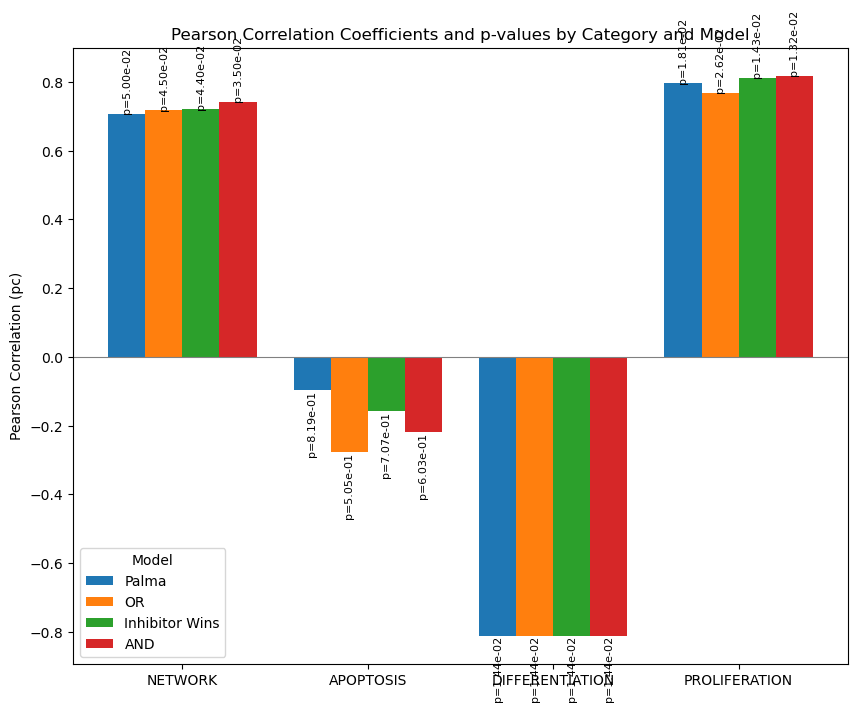

In [131]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = hazard_ratio_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

def plot_df(df, ax, position, label):
    bars = ax.bar(x + position * width, df['pc'], width, label=label)
    # Annotate p-value on each bar
    for bar, p_value in zip(bars, df['p_value']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.2e}', 
                ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=8, rotation=90)

# Plot each dataframe
plot_df(hazard_ratio_pc_palma, ax, -1.5, 'Palma')
plot_df(hazard_ratio_pc_or, ax, -0.5, 'OR')
plot_df(hazard_ratio_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(hazard_ratio_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values by Category and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

**The phenotype scores correlate significantly with the death hazard ratio, which higher correlations and more significant p-values compared with the results from the Palma model alone.**   

### Clinical outcomes
>We next investigated the prognostic power of our model by comparing it with additional clinical features derived from the AML TGCA dataset. Specifically, we compared the mutation-specific peripheral blood (PB) and bone marrow (BM) blast percentages with the predictions of our models.
   
Mutation and clinical data are downloaded from the [NIH GDC website](https://gdc.cancer.gov/about-data/publications/laml_2012):
1. [Supplemental Table 06: All somatic mutations with annotation and readcounts from DNA and RNA sequencing](SupplementalTable06.tsv)
2. [Patient Clinical Data](https://portal.gdc.cancer.gov/files/c07a64a0-7588-4653-95ef-982b41a1a804?aeTable_offset=20)

In [35]:
def clinical_pc(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    clinicals = ['PB_BLAST', 'BM_BLAST']
    
    clinical_pc_results = pd.DataFrame()
    
    for clinical in clinicals:
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        clinical_pc_results.loc[clinical, 'pc'], clinical_pc_results.loc[clinical, 'p_value'] = pearsonr(x, y)
    return clinical_pc_results
    
def clinical_plot(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    clinicals = ['PB_BLAST', 'BM_BLAST']
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, clinical in enumerate(clinicals):
        ax = axes[i]
        # Extract network scores and clinical outcome values
        x = clinical_results.loc['NETWORK', :]
        y = clinical_results.loc[clinical, :]
        
        # Calculate Pearson Correlation and p-value
        pc, p_value = pearsonr(x, y)
    
        # Linear regression (best-fit line)
        slope, intercept = np.polyfit(x, y, 1)
        ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
        
        # Create scatterplot
        ax.scatter(x, y)
        ax.set_title(f'{clinical} vs Network score')
        ax.set_xlabel('Network score')
        ax.set_ylabel('%' + clinical)
    
            # Annotate each data point
        for j in range(len(x)):
            label = x.index[j]
            ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')
    
        
        # Annotate Pearson Correlation and p-value
        ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
                transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

def clinical_plot_pb(simulation_results, clinical_file):
    clinical_aggr = pd.read_csv(clinical_file,index_col=0)
    clinical_results = pd.concat([clinical_aggr.T.sort_index(axis=1),simulation_results.sort_index(axis=1)])
    
    # Plotting scatterplots
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Extract network scores and clinical outcome values
    x = clinical_results.loc['NETWORK', :]
    y = clinical_results.loc['PB_BLAST', :]
    
    # Calculate Pearson Correlation and p-value
    pc, p_value = pearsonr(x, y)

    # Linear regression (best-fit line)
    slope, intercept = np.polyfit(x, y, 1)
    ax.plot(x, slope*x + intercept, color='purple')  # Plotting the best-fit line
    
    # Create scatterplot
    ax.scatter(x, y)
    ax.set_title('Blast percentage vs Network score')
    ax.set_xlabel('Network score')
    ax.set_ylabel('Blast percentage')

    # Annotate each data point
    for j in range(len(x)):
        label = x.index[j]
        ax.annotate(label, (x.iloc[j], y.iloc[j]), textcoords="offset points", xytext=(0,7), ha='center')

    
    # Annotate Pearson Correlation and p-value
    ax.text(0.95, 0.05, f'PC: {pc:.2f}\np-value: {p_value:.2e}',
            transform=ax.transAxes, horizontalalignment='right')
        
    plt.tight_layout()
    plt.show()

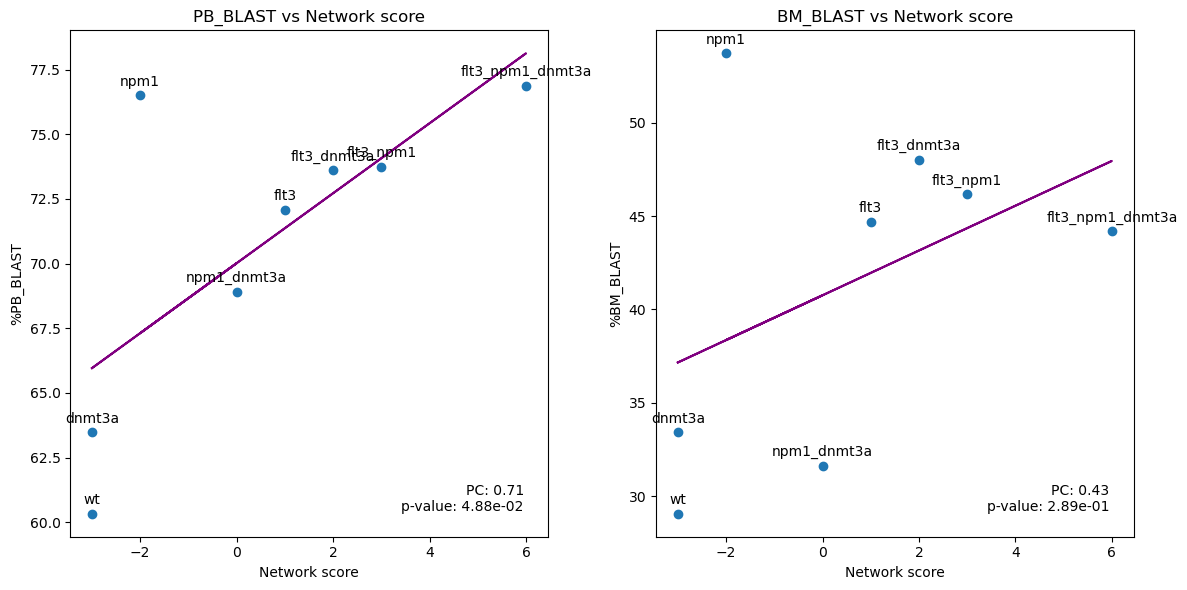

In [36]:
clinical_pc_palma = clinical_pc(simulation_results_palma, 'clinical.csv')
clinical_plot(simulation_results_palma, 'clinical.csv')

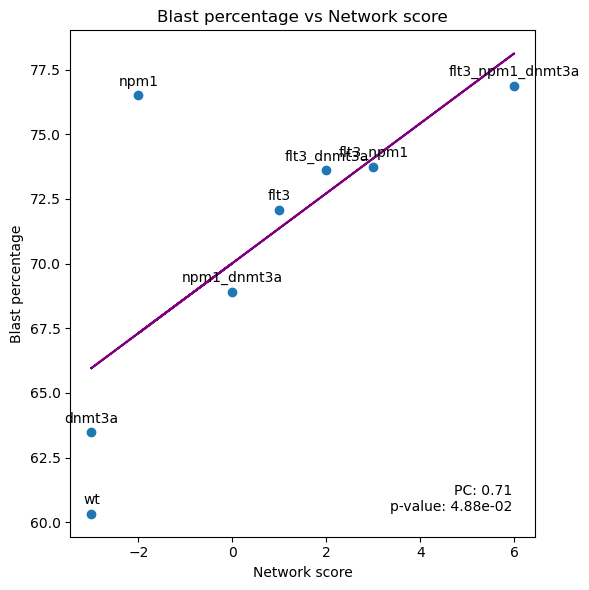

In [37]:
clinical_plot_pb(simulation_results_palma, 'clinical.csv')

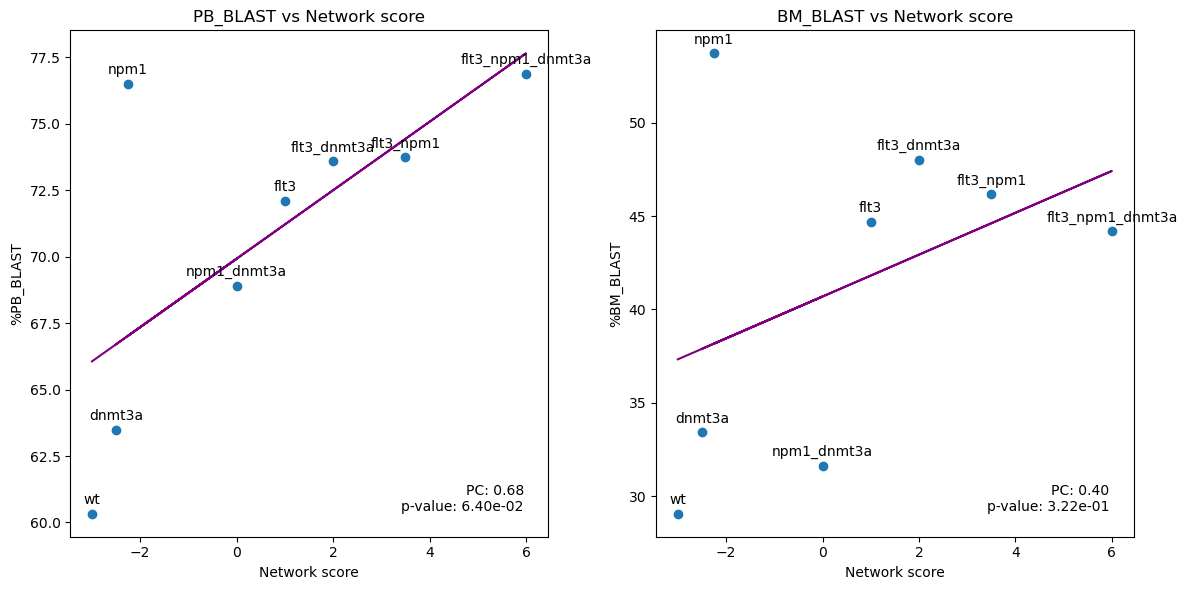

In [38]:
clinical_pc_or = clinical_pc(simulation_results_or, 'clinical.csv')
clinical_plot(simulation_results_or, 'clinical.csv')

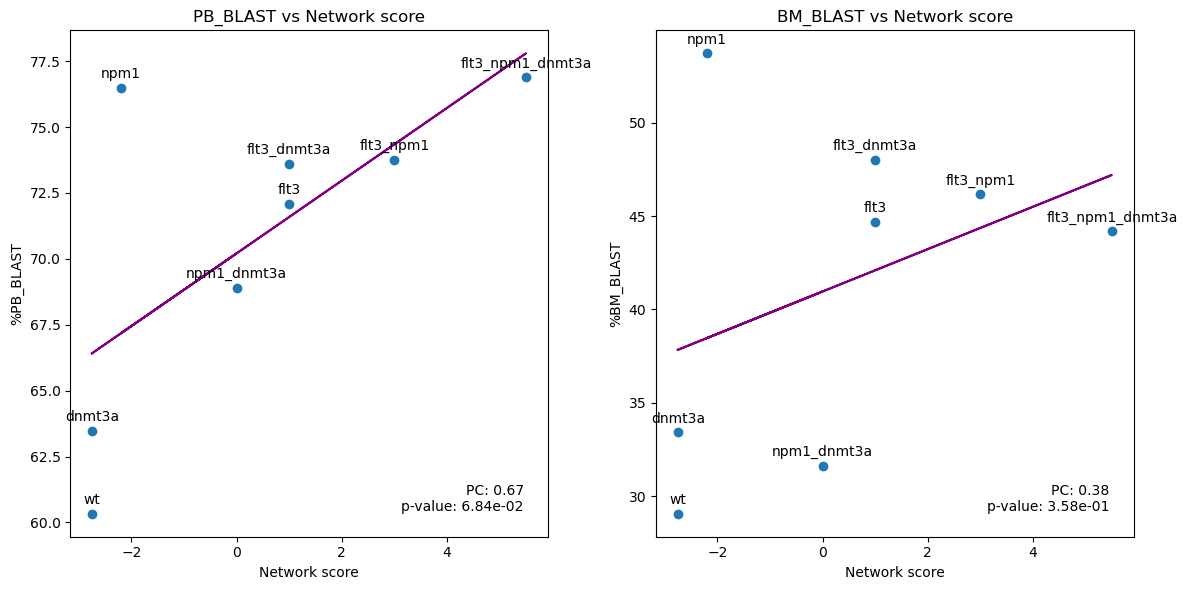

In [39]:
clinical_pc_inhibitor_wins = clinical_pc(simulation_results_inhibitor_wins, 'clinical.csv')
clinical_plot(simulation_results_inhibitor_wins, 'clinical.csv')

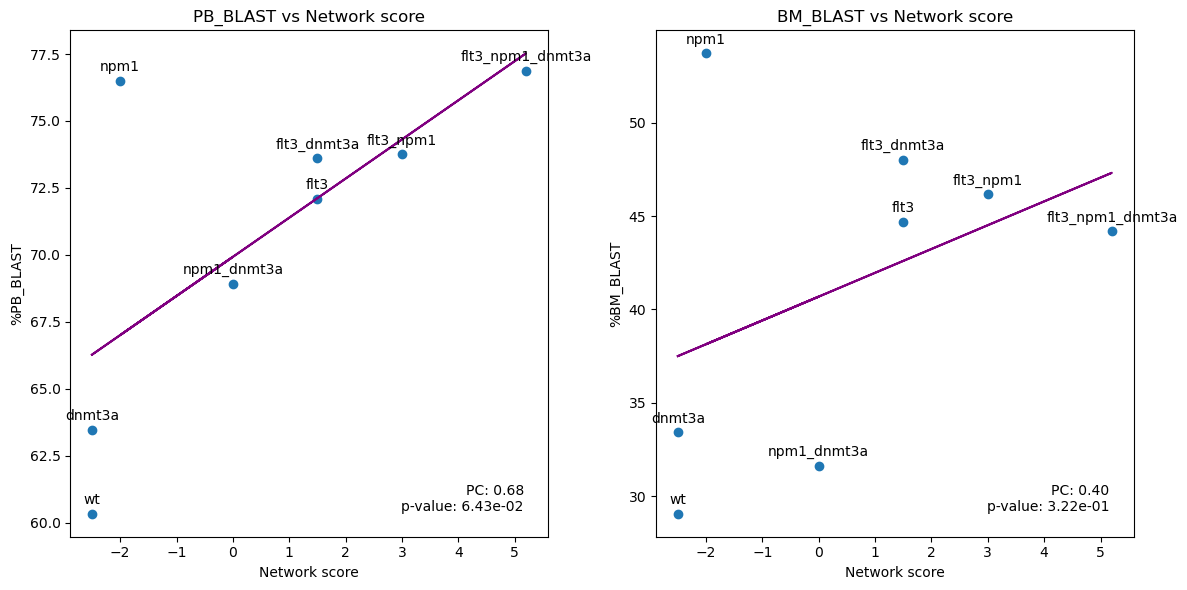

In [40]:
clinical_pc_and = clinical_pc(simulation_results_and, 'clinical.csv')
clinical_plot(simulation_results_and, 'clinical.csv')

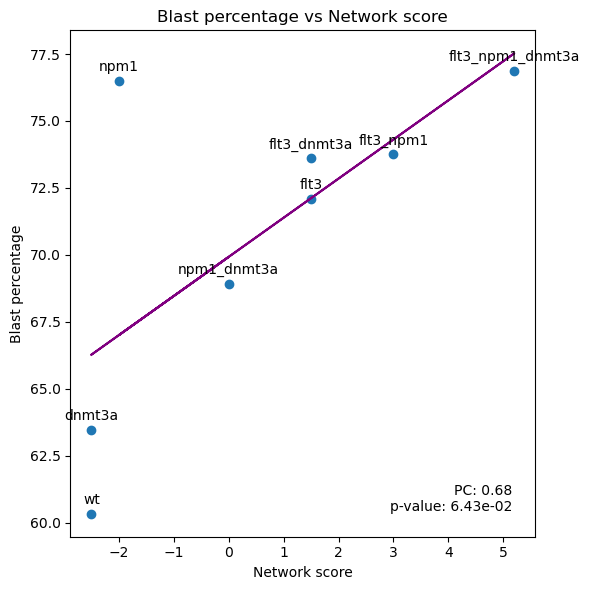

In [41]:
clinical_plot_pb(simulation_results_and, 'clinical.csv')

In [44]:
display_side_by_side([clinical_pc_palma, clinical_pc_or, clinical_pc_inhibitor_wins, clinical_pc_and], titles=titles)

,pc,p_value
PB_BLAST,0.709216,0.048842
BM_BLAST,0.428700,0.289242
,pc,p_value
PB_BLAST,0.679161,0.063973
BM_BLAST,0.402807,0.322457
,pc,p_value
PB_BLAST,0.671175,0.068407
BM_BLAST,0.376352,0.358142
,pc,p_value
PB_BLAST,0.678583,0.064288


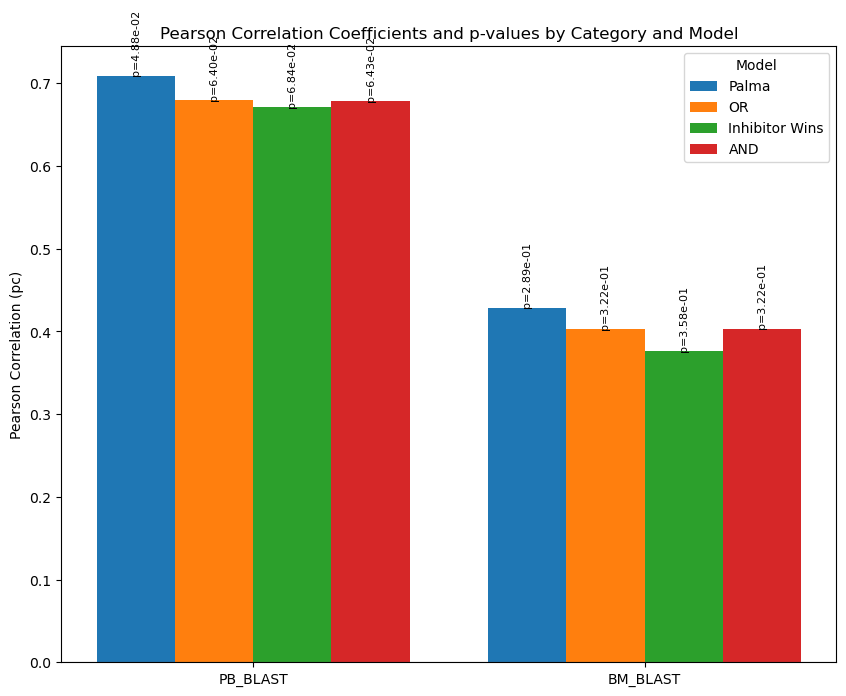

In [132]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = clinical_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

# Plot each dataframe
plot_df(clinical_pc_palma, ax, -1.5, 'Palma')
plot_df(clinical_pc_or, ax, -0.5, 'OR')
plot_df(clinical_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(clinical_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values by Category and Model')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

**There result is slightly worse compared with Palma's for both peripheral blood (PB) blast cell percentage and bone marrow (BM) blast cell percentage.**  

## Using the ProxPath to define phenotype scores

An algorithm that, given a set of proteins, estimates its regulatory impact over phenotypes and pathways annotated in SIGNOR.
   
I have checked that nodes derived from the ProxPath cover all nodes in Palma's calculation function.

In [177]:
%run '../ProxPath.ipynb'

# the Palma results
nodes_palma = getnodes("Palma2021_nophe.sbml")
pheno_palma = proxpath(nodes_palma)
simulation_results_palma_new = pheno_scores(simulation_results_palma, pheno_palma)
simulation_results_palma_new.loc['NETWORK'] = simulation_results_palma_new.loc['PROLIFERATION'] - simulation_results_palma_new.loc['APOPTOSIS'] - simulation_results_palma_new.loc['DIFFERENTIATION']
hazard_ratio_pc_palma = hazard_ratio_pc(simulation_results_palma_new, 'Hazard Ratio for Death.csv')
clinical_pc_palma = clinical_pc(simulation_results_palma_new, 'clinical.csv')


# the 'OR' results
nodes_or = getnodes("merged_or.sbml")
pheno_or = proxpath(nodes_or)
simulation_results_or_new = pheno_scores(simulation_results_or, pheno_or)
simulation_results_or_new.loc['NETWORK'] = simulation_results_or_new.loc['PROLIFERATION'] - simulation_results_or_new.loc['APOPTOSIS'] - simulation_results_or_new.loc['DIFFERENTIATION']
hazard_ratio_pc_or = hazard_ratio_pc(simulation_results_or_new, 'Hazard Ratio for Death.csv')
clinical_pc_or = clinical_pc(simulation_results_or_new, 'clinical.csv')

# the 'Inhibitor wins' results
nodes_in = getnodes("merged_inhibitor_wins.sbml")
pheno_in = proxpath(nodes_in)
simulation_results_inhibitor_wins_new = pheno_scores(simulation_results_inhibitor_wins, pheno_in)
simulation_results_inhibitor_wins_new.loc['NETWORK'] = simulation_results_inhibitor_wins_new.loc['PROLIFERATION'] - simulation_results_inhibitor_wins_new.loc['APOPTOSIS'] - simulation_results_inhibitor_wins_new.loc['DIFFERENTIATION']
hazard_ratio_pc_in = hazard_ratio_pc(simulation_results_inhibitor_wins_new, 'Hazard Ratio for Death.csv')
clinical_pc_in = clinical_pc(simulation_results_inhibitor_wins_new, 'clinical.csv')

# the 'AND' results
nodes_and = getnodes("merged_and.sbml")
pheno_and = proxpath(nodes_and)
simulation_results_and_new = pheno_scores(simulation_results_and, pheno_and)
simulation_results_and_new.loc['NETWORK'] = simulation_results_and_new.loc['PROLIFERATION'] - simulation_results_and_new.loc['APOPTOSIS'] - simulation_results_and_new.loc['DIFFERENTIATION']
hazard_ratio_pc_and = hazard_ratio_pc(simulation_results_and_new, 'Hazard Ratio for Death.csv')
clinical_pc_and = clinical_pc(simulation_results_and_new, 'clinical.csv')

In [180]:
pheno_or

,EndPathways,QueryNode,EndNode,Path_String,relations_path,Path_Score,Path_Length,Final_Effect,Effect,n,mean,sd,zscore,Closest_Gene
2894,APOPTOSIS,TP53,APOPTOSIS,TP53-->APOPTOSIS,SIGNOR-255678,0.300,1,1,up-regulates,75493,1.737625,0.526944,-2.728233,TP53
2896,APOPTOSIS,MAPK1,APOPTOSIS,MAPK1-->FOS-->JUN--|APOPTOSIS,SIGNOR-262996;SIGNOR-252087;SIGNOR-256560,0.578,3,-1,down-regulates,75493,1.737625,0.526944,-2.200663,MAPK1
2913,APOPTOSIS,BCL2,APOPTOSIS,BCL2--|APOPTOSIS,SIGNOR-249611,0.300,1,-1,down-regulates,75493,1.737625,0.526944,-2.728233,BCL2
2918,APOPTOSIS,FOXO3,APOPTOSIS,FOXO3-->APOPTOSIS,SIGNOR-217887,0.300,1,1,up-regulates,75493,1.737625,0.526944,-2.728233,FOXO3
2946,APOPTOSIS,MAPK1,APOPTOSIS,MAPK1--|FOXO-->APOPTOSIS,SIGNOR-252958;SIGNOR-252939,0.604,2,-1,down-regulates,75493,1.737625,0.526944,-2.151321,MAPK1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54562,PROLIFERATION,MAPK1,PROLIFERATION,MAPK1--|FOXO--|PROLIFERATION,SIGNOR-252958;SIGNOR-252938,0.604,2,1,up-regulates,107507,1.681607,0.506006,-2.129632,MAPK1
54621,PROLIFERATION,RB1,PROLIFERATION,RB1--|PROLIFERATION,SIGNOR-262533,0.300,1,-1,down-regulates,107507,1.681607,0.506006,-2.730415,RB1
54650,PROLIFERATION,AKT1,PROLIFERATION,AKT1--|RAC1-->PROLIFERATION,SIGNOR-252576;SIGNOR-255648,0.587,2,-1,down-regulates,107507,1.681607,0.506006,-2.163228,AKT1
54681,PROLIFERATION,MTOR,PROLIFERATION,MTOR-->AKT1-->MTORC1-->PROLIFERATION,SIGNOR-170604;SIGNOR-255844;SIGNOR-256063,0.672,3,1,up-regulates,107507,1.681607,0.506006,-1.995246,MTOR


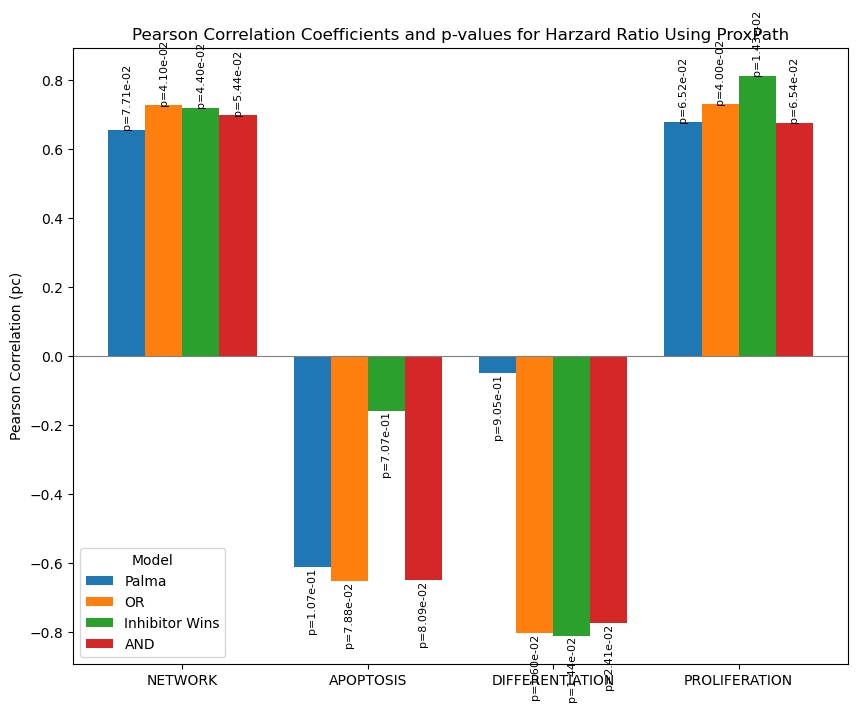

In [173]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = hazard_ratio_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

def plot_df(df, ax, position, label):
    bars = ax.bar(x + position * width, df['pc'], width, label=label)
    # Annotate p-value on each bar
    for bar, p_value in zip(bars, df['p_value']):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'p={p_value:.2e}', 
                ha='center', va='bottom' if bar.get_height() > 0 else 'top', fontsize=8, rotation=90)

# Plot each dataframe
plot_df(hazard_ratio_pc_palma, ax, -1.5, 'Palma')
plot_df(hazard_ratio_pc_or, ax, -0.5, 'OR')
plot_df(hazard_ratio_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(hazard_ratio_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values for Harzard Ratio Using ProxPath')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

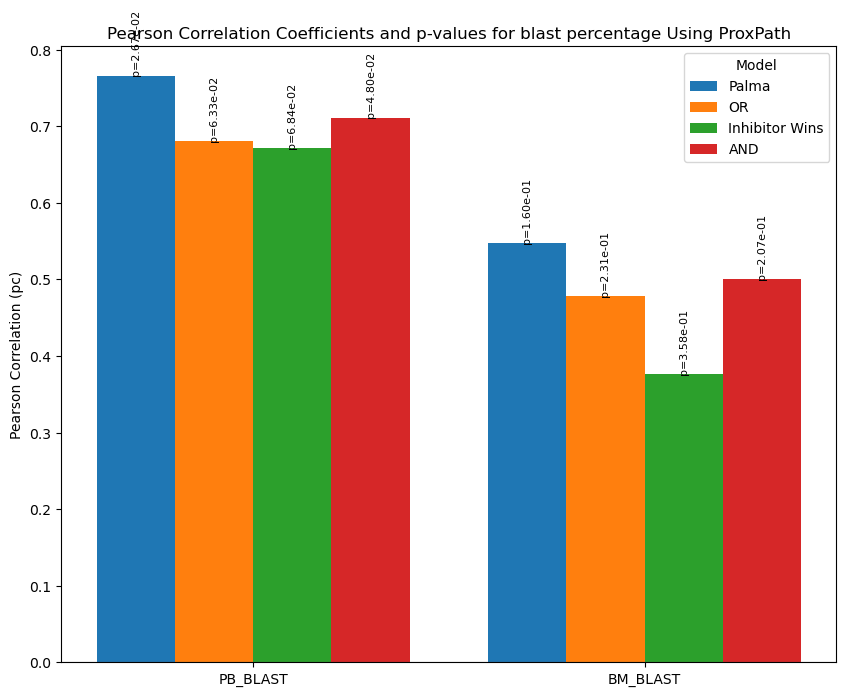

In [174]:
fig, ax = plt.subplots(figsize=(10, 8))

categories = clinical_pc_palma.index
x = np.arange(len(categories))  # the label locations
width = 0.2  # the width of the bars

# Plot each dataframe
plot_df(clinical_pc_palma, ax, -1.5, 'Palma')
plot_df(clinical_pc_or, ax, -0.5, 'OR')
plot_df(clinical_pc_inhibitor_wins, ax, 0.5, 'Inhibitor Wins')
plot_df(clinical_pc_and, ax, 1.5, 'AND')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Pearson Correlation (pc)')
ax.set_title('Pearson Correlation Coefficients and p-values for blast percentage Using ProxPath')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.axhline(0, color='grey', linewidth=0.8)
ax.legend(title='Model')

plt.show()

## Conclusion
**Merging of the Palma et al. 2021 model and Ikonomi et al. 2020 model is feasible, but the performance against clinical data varys. (The 'AND' model is slightly better?)** 

By combining the Nensi Ikonomi et al., Front Physiol. 2020 model and the Palma et al, J Pers Med. 2021 model, we may be able to capture how AML mutations affect the differentiation, proliferation of the AML cells and the behavior of HSC. At the same time, by introducing drug intervention, we may be able to estimate how the drugs impact AML cancer cells as well as HSC status.
   
In order to test the potential drug intervention, it would be great to have some drug response data with the mutation profile.